# $sin(x + y)$
This notebook shows how you can use a Gaussian Process to estimate a
2-dimensional function $f(x, y) = sin(x + y)$.

In [1]:
%matplotlib notebook

In [2]:
from __future__ import print_function

import torch
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

from gp import GaussianProcess
from gp.kernels import RBFKernel, WhiteNoiseKernel

In [3]:
def secret_function(x, noise=0.0):
    # sin(x + y)
    x_sum = x.sum(dim=-1).reshape(-1, 1)
    return x_sum.sin() + noise * torch.randn(x_sum.shape)

We sample 50 pairs of points $(x, y)$ four times and push them through our *secret* function. We reuse the same points simply to show that the function is noisy and that the Gaussian Process is robust against it.

In [4]:
# Training data.
X = (10 * torch.rand(100, 1) - 4).reshape(50, 2)
X = torch.cat([X] * 4)
Y = secret_function(X, noise=1e-1)

In [5]:
# Test data.
DATA_SIZE = 100
x = np.linspace(-4, 4, DATA_SIZE)
y = np.linspace(-4, 4, DATA_SIZE)
x, y = np.meshgrid(x, y)  # We need a grid for 3D plot.

# Real function.
x_ = torch.tensor(x, dtype=torch.float32)
y_ = torch.tensor(y, dtype=torch.float32)
x_test = torch.stack([x_, y_]).reshape(2, -1).t()
z = secret_function(x_test).reshape(DATA_SIZE, DATA_SIZE)

<IPython.core.display.Javascript object>


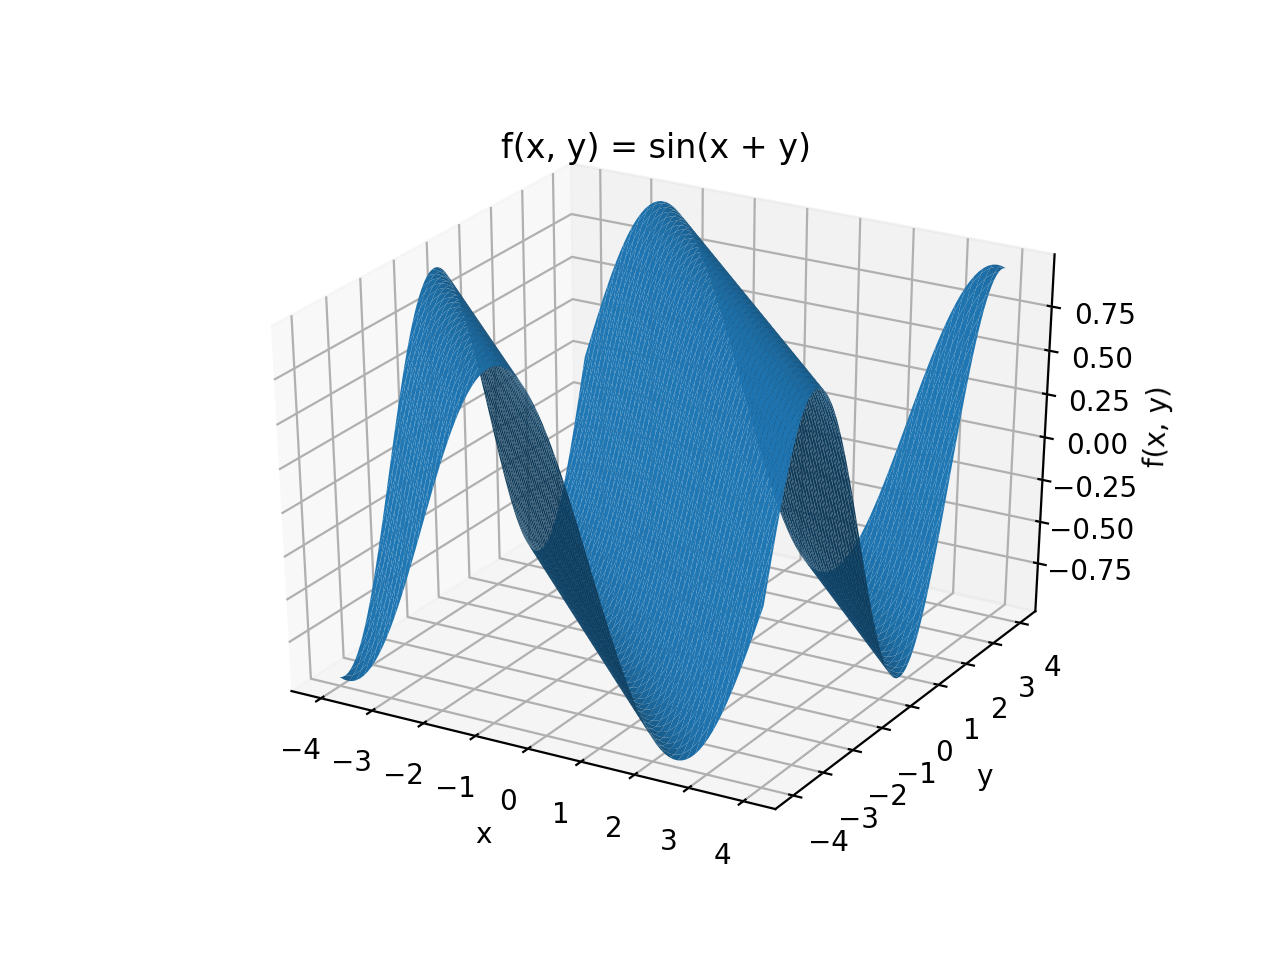

Text(0.5,0,'f(x, y)')

In [6]:
# Plot the real function.
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(x, y, z.numpy())
ax.set_title("f(x, y) = sin(x + y)")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("f(x, y)")

In [7]:
# Fit the Gaussian Process.
# Use a vector length scale.
k = RBFKernel(length_scale=torch.randn(2)) + WhiteNoiseKernel()
gp = GaussianProcess(k, X, Y)
gp.fit()

1000

In [8]:
z_test, std_dev = gp(x_test, return_std=True)
z_test = z_test.reshape(DATA_SIZE, DATA_SIZE)
std_dev = std_dev.reshape(DATA_SIZE, DATA_SIZE)

In [9]:
std_dev_norm = std_dev / std_dev.max()
m = cm.ScalarMappable(cmap=cm.inferno)
m.set_array(std_dev_norm.detach().numpy())
colors = m.to_rgba(std_dev_norm.detach().numpy())

<IPython.core.display.Javascript object>


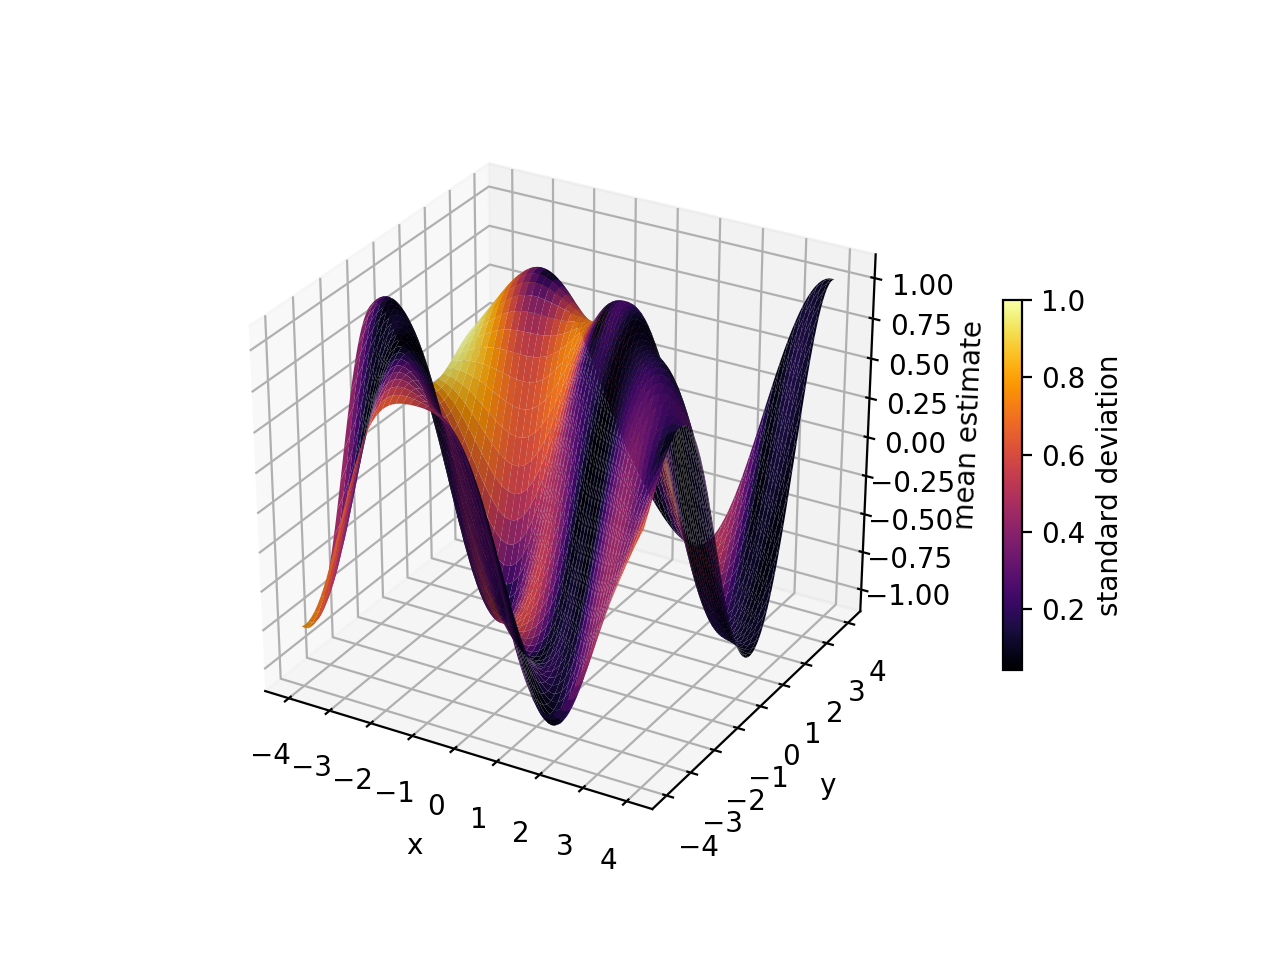

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
surf = ax.plot_surface(x, y, z_test.detach().numpy(), facecolors=colors, linewidth=0, antialiased=True)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("mean estimate")
cb = plt.colorbar(m, shrink=0.5)
cb.set_label("standard deviation")

<IPython.core.display.Javascript object>


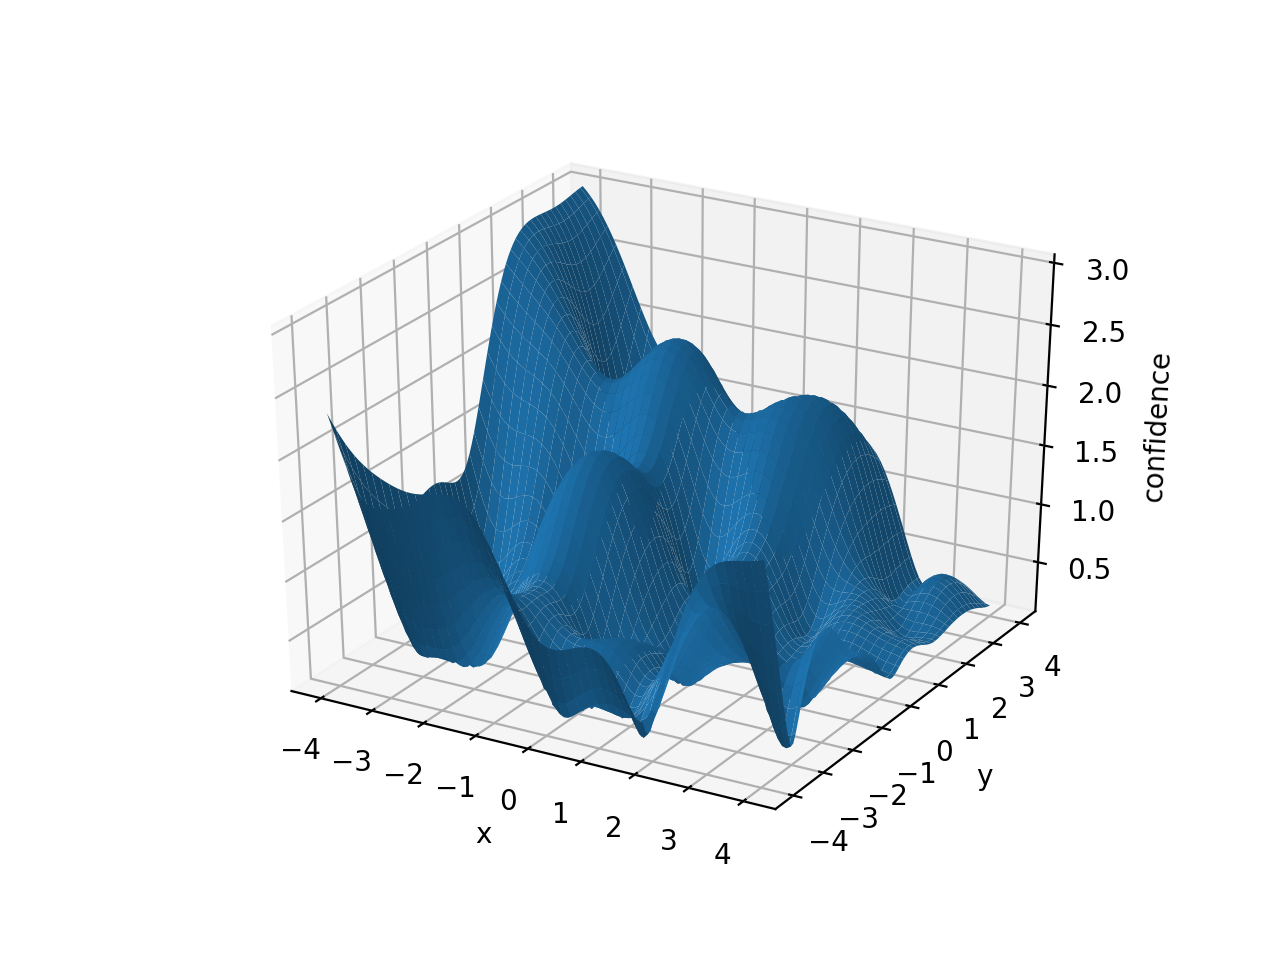

Text(0.5,0,'confidence')

In [11]:
# Plot uncertainty as 3 standard deviations.
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(x, y, 3 * std_dev.detach().numpy())
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("confidence")